# Práctica 2

**Nombre:** Anahí Barajas Pérez  
**e-mail:** anahi.barajas2412@alumnos.udg.mx

## MODULES

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from plotly.subplots import make_subplots
import plotly.graph_objects as go


from scipy.stats import wrapcauchy
from scipy.stats import levy_stable

import os

## CLASSES

In [2]:
################# http://www.pygame.org/wiki/2DVectorClass ##################
class Vec2d(object):
    """2d vector class, supports vector and scalar operators,
       and also provides a bunch of high level functions
       """
    __slots__ = ['x', 'y']

    def __init__(self, x_or_pair, y = None):
        if y == None:            
            self.x = x_or_pair[0]
            self.y = x_or_pair[1]
        else:
            self.x = x_or_pair
            self.y = y
            
    # Addition
    def __add__(self, other):
        if isinstance(other, Vec2d):
            return Vec2d(self.x + other.x, self.y + other.y)
        elif hasattr(other, "__getitem__"):
            return Vec2d(self.x + other[0], self.y + other[1])
        else:
            return Vec2d(self.x + other, self.y + other)

    # Subtraction
    def __sub__(self, other):
        if isinstance(other, Vec2d):
            return Vec2d(self.x - other.x, self.y - other.y)
        elif (hasattr(other, "__getitem__")):
            return Vec2d(self.x - other[0], self.y - other[1])
        else:
            return Vec2d(self.x - other, self.y - other)
    
    # Vector length
    def get_length(self):
        return math.sqrt(self.x**2 + self.y**2)
    
    # rotate vector
    def rotated(self, angle):        
        cos = math.cos(angle)
        sin = math.sin(angle)
        x = self.x*cos - self.y*sin
        y = self.x*sin + self.y*cos
        return Vec2d(x, y)

## Actividad 1: Lévy distribution - N Curves (3 pts)

* Generar al menos las 4 curvas de distribución timpo Lévy stable que se observan en la imagen
* Visualizar con **plotly**

* Parametros m = 3.0, Levy_exponent = x, beta = 0

In [3]:
std_motion_steps = 3.0
beta = 0
size = 500
Levy_exponent = [0.1, 0.5, 1.0, 1.9]


fig_Levy_pdf = go.Figure()
aux_domain = np.linspace(std_motion_steps-5, std_motion_steps+5, size)

for a in Levy_exponent:
    
    Levy_pdf = np.array([levy_stable.pdf(i, alpha = a, beta = beta, loc =std_motion_steps) for i in aux_domain])
    
    fig_Levy_pdf.add_trace(go.Scatter(x = aux_domain,
                                  y = Levy_pdf,
                                  marker = dict(size=2),
                                  line = dict(width=2),
                                  mode = 'lines',
                                  name = 'Levy_'+str(a),
                                  showlegend = True))

fig_Levy_pdf.show()                      

## Actividad 2: Lévy distribution - Histogram + Curve (4 pts)

* A partir de un conjunto de valores aleatorios extraidos de una distribución tipo Lévy stable, obtener su histograma y comparar con la curva correspondiente PDF
* Visualizar con **matplotlib**

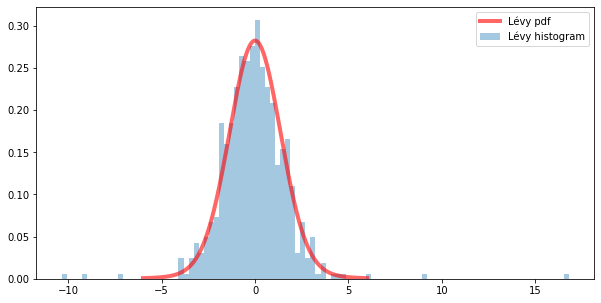

In [4]:
# Parametros de la distribución
Levy_exponent = 1.9
beta = 0
size = 600

levy_stable_rvs = levy_stable.rvs(Levy_exponent,beta,size=size)

aux_domain = np.linspace(-6,6,size)
levy_stable_pdf = np.array([levy_stable.pdf(i, Levy_exponent ,beta) for i in aux_domain])

fig,ax = plt.subplots(1,1)
fig.set_figheight(5)
fig.set_figwidth(10)

ax.hist(levy_stable_rvs,bins=100, density=True, histtype='stepfilled',alpha=0.4, label='Lévy histogram')
ax.plot(aux_domain,levy_stable_pdf,'r-', lw=4, alpha=0.6, label='Lévy pdf')
ax.legend(loc="best")
plt.show()

## Actividad 3: Lévy ﬂight - Vec2d - 1 Trajectory (6 pts)

* Utilizar **Vec2d**
* Guardar trayectorias en **Pandas** Data Frame
* Visualizar proyección en 3d con **plotly**

In [5]:
housing_df = pd.read_csv('/content/sample_data/mnist_test.csv')

# Parametros de la distribución
Levy_exponent = 1.9
beta = 0

n_steps = 5000
s_pos = [0,0]
speed = 6

#init velocity vector
velocity = Vec2d(speed,0)

#Init DataFrame
LF_2d_df = pd.DataFrame(columns=['x_pos','y_pos'])

# DF termporal para concatenar

LF_2d_df = pd.concat([LF_2d_df, pd.DataFrame([{'x_pos': s_pos[0], 'y_pos':s_pos[1]}])], ignore_index=True)
levy_stable_rvs = levy_stable.rvs(Levy_exponent,beta,size=n_steps)

for i in range(n_steps-1):
  velocity = velocity.rotated(levy_stable_rvs[i])
  temp_df = pd.DataFrame([{'x_pos': LF_2d_df.x_pos[i]+velocity.x, 'y_pos': LF_2d_df.y_pos[i]+velocity.y}])
  LF_2d_df = pd.concat([LF_2d_df,temp_df], ignore_index = True)

In [6]:
# Init figure
fig_LF_3d = go.Figure(layout=dict(autosize=False,width = 800,height = 800))

times = np.linspace(0,1,n_steps)

# Plot trajectory
fig_LF_3d.add_trace(go.Scatter3d(x = LF_2d_df.x_pos,
                              y = LF_2d_df.y_pos,
                              z = times,
                              line_width = 2,
                              mode = 'lines',
                              name = 'Lévy Flight_3d',
                              showlegend = True))


## Actividad 4: Correlated Random Walk - Vec2d - N Trajectories (7 pts)

* Generar tantas trayectorias tipo CRW como se especifique en una variable n_traj
* Cada una de las debe tener un coeficiente de Cauchy diferente
* Utilizar **Vec2d**
* Guardar trayectorias en **Pandas** Data Frame
* Visualizar proyección en 3d con **plotly**
* Exportar trayectorias como *pkl*

In [7]:
n_steps = 5000
s_pos = [0,0]
speed = 6
n_traj = 5

# Init velocity vector 
velocity = Vec2d(speed,0)

# Init figure
fig_CRW_3d = go.Figure()
os.mkdir('/content/CRW_pkl/')

for t in range(1,n_traj+1):
  CRW_exponent = np.round(np.random.uniform(low=0, high=1),2)
  rv = wrapcauchy.rvs(CRW_exponent, size=n_steps)
  
  #Init DataFrame
  CRW_2d_df = pd.DataFrame([{'x_pos': s_pos[0], 'y_pos':s_pos[1]}])

  for i in range(n_steps-1):
    
    velocity = velocity.rotated(rv[i])
    temp_df = pd.DataFrame([{'x_pos': CRW_2d_df.x_pos[i]+velocity.x, 'y_pos': CRW_2d_df.y_pos[i]+velocity.y}])
    CRW_2d_df = pd.concat([CRW_2d_df,temp_df], ignore_index = True)

  times = np.linspace(0,1,n_steps)

  # Plot trajectory
  fig_CRW_3d.add_trace(go.Scatter3d(x = CRW_2d_df.x_pos,
                                y = CRW_2d_df.y_pos,
                                z = times,
                                line_width = 2,
                                mode = 'lines',
                                name = 'CRW_3d_'+str(CRW_exponent),
                                showlegend = True))
  



  CRW_2d_df.to_pickle("/content/CRW_pkl/CRW_2d_df_"+str(CRW_exponent)+".pkl")  

  fig_CRW_3d.show()